In [153]:
import os
import pickle

import numpy as np
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
# models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from yellowbrick.classifier import ConfusionMatrix, ROCAUC

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# Load in the Model

In [2]:
with open("../models/rf_classifier_v1.pkl", "rb") as file:
    rf_model = pickle.load(file)

# Load in full data

In [5]:
csvs = []

for root, dirs, files in os.walk("../data/user_labeled/labeled_formatted/"):
    csvs += files
    
csvs

['Digital recording.csv',
 'Starcraft.csv',
 'Evidence-based policy.csv',
 'Exercise_physiology.csv',
 'Prevention science.csv',
 'Mental health.csv',
 '[SKIP]Stargate.csv',
 'Counterpoint.csv',
 'Atmospheric science.csv',
 'Stargate.csv',
 'Decision tree.csv',
 'Sonata form.csv']

In [10]:
dfs = []

for filename in csvs:
    if "SKIP" in filename:
        continue
    labeled = filename
    unlabeled = filename.replace(" ", "_").replace(".csv", ".zip")
    
    # get labeled and unlabeled date for merge
    labeled_df = pd.read_csv(f"../data/user_labeled/labeled_formatted//{labeled}")
    unlabeled_df = pd.read_csv(f"../data/user_labeled/unlabeled/{unlabeled}")
    
    # rename columns in labeled to match those in unlabeled. 
    labeled_df.rename(columns={"Topic": "node", "Before/After": "label"}, inplace=True)
    
    
    merged = labeled_df.merge(unlabeled_df, on="node", how="left")
    
    dfs.append(merged)

    
# combine dfs
total_labeled = dfs[0]
for i in range(1, len(dfs)):
    df = dfs[i]
    total_labeled = pd.concat([total_labeled, df])

total_labeled.label.value_counts()

after     234
before    145
Name: label, dtype: int64

In [13]:
total_labeled

,node,label,degree,category_matches_with_source,in_edges,out_edges,shared_neighbors_with_entry_score,centrality,page_rank,adjusted_reciprocity,shortest_path_length_from_entry,shortest_path_length_to_entry,jaccard_similarity,primary_link,similarity_rank
0,Digital recording,NaN,0.041407,0.5,0.019035,0.237477,1.000000,0.386991,0.049862,0.093777,0.000000,0.00,1.000000,0.0,1.000000
1,Sound-on-film,after,0.025108,1.0,0.014894,0.110699,0.213642,0.288900,0.042975,0.054338,0.166667,0.20,0.131959,0.0,0.499921
2,DA-88,NaN,0.012943,0.5,0.004079,0.093383,0.269815,0.350101,0.010730,0.042945,0.166667,0.20,0.194888,0.0,0.342064
3,High fidelity,before,0.032059,1.0,0.023052,0.100804,0.118135,0.290131,0.052974,0.036810,0.166667,0.40,0.131229,0.0,0.332476
4,Loudspeaker,before,0.010666,0.0,0.005624,0.054422,0.208191,0.150838,0.017363,0.049080,0.166667,0.20,0.216463,1.0,0.326242
5,ADAT,after,0.017857,0.5,0.007911,0.105751,0.266462,0.423408,0.020317,0.049956,0.166667,0.20,0.191257,0.0,0.325117
6,Hard disk recorder,NaN,0.016719,0.5,0.006983,0.103278,0.216418,0.132719,0.013911,0.043821,0.166667,0.20,0.206304,0.0,0.302718
7,Variable Control Voice Actuator,NaN,0.000300,1.0,0.000062,0.003092,0.003396,0.000153,0.000257,0.000000,0.500000,0.20,0.000000,0.0,0.302501
8,Comparison of analog and digital recording,NaN,0.017318,0.5,0.005129,0.128015,0.216814,0.163493,0.013442,0.043821,0.166667,0.20,0.210526,0.0,0.302118
9,Alesis,after,0.006472,0.5,0.004450,0.022882,0.025641,0.039679,0.008860,0.012270,0.166667,0.20,0.018767,0.0,0.285553


# Extract features and targets

In [241]:
# Unlabeled data (to be labeled by current working model)
unlabeled = total_labeled[~total_labeled.label.notnull()]
X_unlabeled = unlabeled.drop(["node", "label", "similarity_rank"], axis=1).dropna()


# Test data (Our user labeled data)
user_labeled = total_labeled.dropna()

X_test = user_labeled.drop(["node", "label", "similarity_rank"], axis=1)
y_test = user_labeled.label

# Make Predictions on X_unlabeled & See to Class Imbalance

In [242]:
y_preds = rf_model.predict(X_unlabeled)

In [243]:
X_train = X_unlabeled
y_train = y_preds

cols = X_train.columns

ros = RandomOverSampler()
rus = RandomUnderSampler()
smote = SMOTE()

# class imbalance oversampling 
# X_train, y_train = rus.fit_sample(X_train, y_train)
# X_train = pd.DataFrame(X_train, columns=cols)
# y_train = pd.Series(y_train)

# y_train.value_counts()

after     262
before    262
dtype: int64

In [262]:
# The full data for training our final model
X_full = pd.concat([X_test, X_train])
y_full = pd.concat([y_test, y_train])

# Test set class imbalance

In this case, the test set is our true, human labeled data

In [244]:
ros = RandomOverSampler()
rus = RandomUnderSampler()
smote = SMOTE()

# class imbalance oversampling 
X_test, y_test = rus.fit_sample(X_test, y_test)
X_test = pd.DataFrame(X_test, columns=cols)
y_test = pd.Series(y_test)

y_test.value_counts()

before    144
after     144
dtype: int64

___
# New Models
## Random Forest

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished
/home/qdizon/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Params:	 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 10, 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 1000} 


              precision    recall  f1-score   support

       after       0.78      0.76      0.77       144
      before       0.76      0.78      0.77       144

    accuracy                           0.77       288
   macro avg       0.77      0.77      0.77       288
weighted avg       0.77      0.77      0.77       288

Train Score:	 0.9007633587786259
Test Score:	 0.7708333333333334


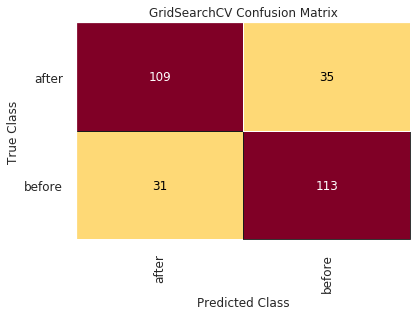

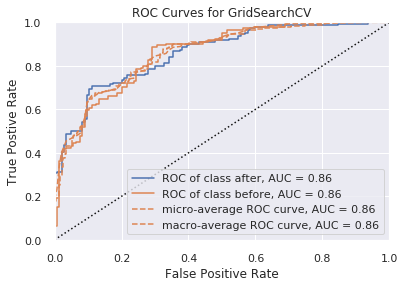

In [263]:
rf2 = RandomForestClassifier(n_jobs=-1)

params = {
#     "pca__n_components": [4,5,6,7,8,9],
    "criterion": ["entropy"], # entropy
    "n_estimators": [1000], # 100
    "max_depth": [10], # 10
    "min_samples_split": [5], # 5
    "min_samples_leaf": [20], # 10
    "max_leaf_nodes": [10], # 8
    "bootstrap": [True]  
}

rf2_model = GridSearchCV(rf2, params, cv=3, verbose=1, n_jobs=-1)

rf2_model.fit(X_full, y_full)

y_labeled_preds = rf2_model.predict(X_test)

rf2_model.score(X_test, y_test)

cm = ConfusionMatrix(rf2_model, classes=rf2_model.classes_, is_fitted=True)
visualizer = ROCAUC(rf2_model, classes=rf2_model.classes_, is_fitted=True)

print("Best Params:\t", rf2_model.best_params_, "\n\n")
print(classification_report(y_test, y_labeled_preds, target_names=rf2_model.classes_))
print("Train Score:\t", rf2_model.score(X_train, y_train))
print("Test Score:\t", cm.score(X_test, y_test))
cm.poof()

visualizer.score(X_test, y_test)
visualizer.poof()

# XGBoost 


              precision    recall  f1-score   support

       after       0.70      0.74      0.72       144
      before       0.72      0.69      0.70       144

    accuracy                           0.71       288
   macro avg       0.71      0.71      0.71       288
weighted avg       0.71      0.71      0.71       288

Train Score:	 0.7977099236641222
Test Score:	 0.7118055555555556


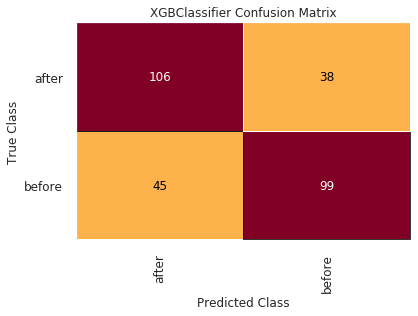

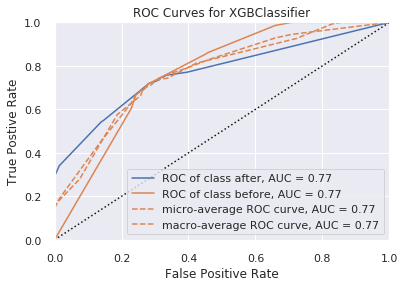

In [264]:
xg_model = XGBClassifier(n_jobs=-1, n_estimators=500, max_depth=1, learning_rate=0.1, gamma=41.9)

# params = {
#     "n_estimators": [1000],
#     "max_depth": [1],
#     "learning_rate": [0.1],
#     "gamma": [4]
# }



xg_model.fit(X_full, y_full)

y_labeled_preds = xg_model.predict(X_test)

xg_model.score(X_test, y_test)

cm = ConfusionMatrix(xg_model, classes=xg_model.classes_, is_fitted=True)
visualizer = ROCAUC(xg_model, classes=xg_model.classes_, is_fitted=True)

print(classification_report(y_test, y_labeled_preds, target_names=xg_model.classes_))
print("Train Score:\t", xg_model.score(X_train, y_train))
print("Test Score:\t", cm.score(X_test, y_test))
cm.poof()

visualizer.score(X_test, y_test)
visualizer.poof()

In [265]:
# save final xgboost to pickle
with open("../models/xg_model_semisupervised_v2.pkl", "wb") as file:
    pickle.dump(xg_model, file)

## XGBoost Gamma Tuning

Text(0, 0.5, 'Accuracy')

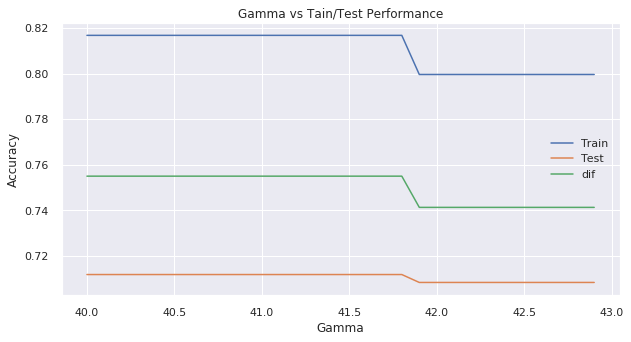

In [251]:
train_scores =[]
test_scores = []

for i in np.arange(40, 43, 0.1):
    xg_model = XGBClassifier(n_jobs=-1, n_estimators=1000, max_depth=1, learning_rate=0.1, gamma=i)
    
    xg_model.fit(X_train, y_train)
    
    train_scores.append([i, xg_model.score(X_train, y_train)])
    test_scores.append([i, xg_model.score(X_test, y_test)])

    
train_scores = np.array(train_scores)
test_scores = np.array(test_scores)
dif = train_scores - test_scores

plt.figure(figsize=(10,5))

sns.lineplot(x=[x[0] for x in train_scores], y=[x[1] for x in train_scores])
sns.lineplot(x=[x[0] for x in test_scores], y=[x[1] for x in test_scores])
sns.lineplot(x=[x[0] for x in train_scores], y=[0.65 + x[1] for x in dif])


plt.title("Gamma vs Tain/Test Performance")
plt.legend(["Train", "Test", "dif"])
plt.xlabel("Gamma")
plt.ylabel("Accuracy")